In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
%matplotlib inline

In [2]:
MNIST = datasets.fetch_openml('mnist_784', version=1)

In [3]:
X, y = MNIST['data'], MNIST['target']
y = y.astype(np.uint8)

In [4]:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

In [9]:
X
some_digit = X.iloc[0]

## Binary classification

#### Stochastic Gradient Classifier

In [5]:
y_train_fives = (y_train == 5)
y_test_fives = (y_test == 5)

In [6]:
from sklearn import linear_model
sgd_clf = linear_model.SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_fives)

SGDClassifier(random_state=42)

In [145]:
sgd_clf.predict([some_digit])

/Users/ikwang/.pyenv/versions/3.10.0/lib/python3.10/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

### Evaluating Performance

In [7]:
# use cross val predict to obtain predictions
from sklearn.model_selection import cross_val_predict
y_pred_fives = cross_val_predict(sgd_clf, X_train, y_train_fives, cv=3)

In [8]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_fives, y_pred_fives)

array([[53892,   687],
       [ 1891,  3530]])

In [52]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, roc_auc_score

print('precision score: {}\nrecall score: {}'.format(
    precision_score(y_train_fives, y_pred_fives),
    recall_score(y_train_fives, y_pred_fives)
))

precision score: 0.8370879772350012
recall score: 0.6511713705958311


Note: we tune the performance of our classifier(increasing precision or increasing recall) based on the context and solution requirements of the problem we are trying to solve.

* Recall - also known as true positive rate, means how many positive examples did our model see for a class

* Precision - the accuracy of our models postive predictions on the class

### Selecting Treshold to tweak recall and precision
Instead of getting predicitons (from the cross_val_predict function), scores or probs so we can set threshold.

Certain classifiers use a decision function to predict the class by setting a threshold value

In [11]:
y_scores_sgd = cross_val_predict(sgd_clf, X_train, y_train_fives, cv=3, method='decision_function')
print('sgd_scores: {}'.format(y_scores_sgd))

sgd_scores: [  1200.93051237 -26883.79202424 -33072.03475406 ...  13272.12718981
  -7258.47203373 -16877.50840447]


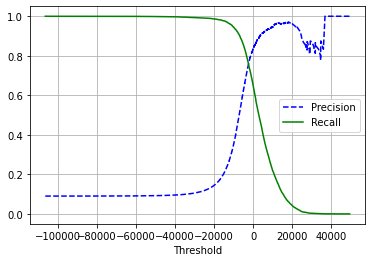

In [12]:
# use scores to plot precision and recall against respective threshold values
precisions, recalls, thresholds = precision_recall_curve(y_train_fives, y_scores_sgd)

# visualize precision and recall
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g', label='Recall')
    plt.xlabel('Threshold')
    plt.legend()
    plt.grid()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()
    

Precision demanded: 90%
Equivalent recall observed: 40% -ish


In [13]:
# threshold to meet required precision
threshold_sgd = thresholds[np.argmax(precisions >= 0.9)]
print('threshold to obtain 90% precision: {}'.format(threshold_sgd))

threshold to obtain 90% precision: 3370.019499143958


In [15]:
# to predict
y_pred_fives_prec_90 = (y_scores_sgd >= threshold_sgd)

# obtain precision and recall
print(
    '''precision of classifier with selected threshold: {}\nrecall of classifier with selected threshold: {}'''.format(
        precision_score(y_train_fives, y_pred_fives_prec_90),
        recall_score(y_train_fives, y_pred_fives_prec_90)
    ))

precision of classifier with selected threshold: 0.9000345901072293
recall of classifier with selected threshold: 0.4799852425751706


##### ROC
Poor recall <br>
To fix that, we use ROC (TPR v FPR) <br>
ROC_AUC is used to compare two classifiers

In [17]:
from sklearn.metrics import roc_curve

fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(y_train_fives, y_scores_sgd)

# plot ROC curve
def plot_roc_curve(fpr, tpr, labels=None, compare_clf=False):
    '''Visualizes the ROC of two models'''
    if compare_clf:
        plt.plot(fpr[0], tpr[0], linewidth=2, label=labels[0])
        plt.plot(fpr[1], tpr[1], 'b:', linewidth=2, label=labels[1])
        plt.plot([0, 1], [0, 1], 'k:')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid()    
    else:
        plt.plot(fpr, tpr, linewidth=2, label=labels)
        plt.plot([0, 1], [0, 1], 'k:')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.grid()    

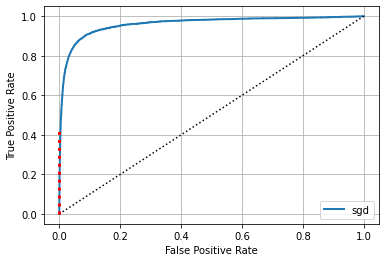

In [19]:
plot_roc_curve(fpr_sgd, tpr_sgd, 'sgd')
plt.plot([0, 0], [0, 0.4368], 'r:', linewidth=3)

Selecting a recall (TPR) of **0.68** might be a better solution than what we currently have <br>
*where the redline terminates is our current classifier recall ~ 0.0 FPR*

#### RandomForestClassifier

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier().fit(X_train, y_train_fives)

# get scores/probability
y_scores_forest = cross_val_predict(forest_clf, X_train, y_train_fives, cv=4, method='predict_proba')


precisions_2, recalls_2, thresholds_2 = precision_recall_curve(y_train_fives, y_scores_forest[:,1])

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_fives, y_scores_forest[:,1])

##### precisions, recalls v thresholds

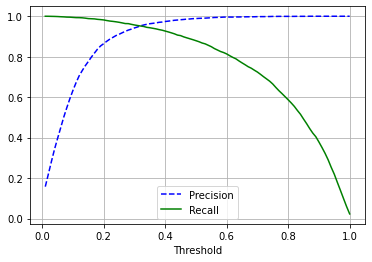

In [28]:
# visualize precisions and recall for the forest clf

plot_precision_recall_vs_threshold(precisions_2, recalls_2, thresholds_2)

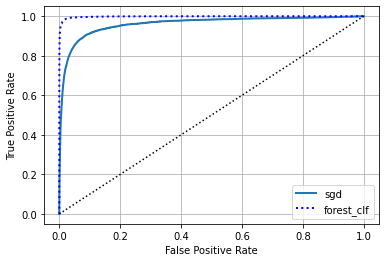

In [22]:
fpr = [fpr_sgd, fpr_forest]
tpr = [tpr_sgd, tpr_forest]

plot_roc_curve(fpr, tpr, labels=['sgd', 'forest_clf'], compare_clf=True)

the random forest classifier outperforms the sgd clf model <br>
It can attain a recall of 80+% and stil have a great zero FPR which can mean great precision.

In [57]:
# compare both classifiers
(roc_auc_score(y_train_fives, y_scores_sgd) < roc_auc_score(y_train_fives, y_scores_forest[:,1]))

True